In [7]:
%pip install tensorflow mlflow

    100% |████████████████████████████████| 14.8MB 1.6MB/s ta 0:00:011   29% |█████████▌                      | 4.4MB 7.7MB/s eta 0:00:02


  Found existing installation: numpy 1.16.2
    Uninstalling numpy-1.16.2:
      Successfully uninstalled numpy-1.16.2
  Found existing installation: cloudpickle 0.8.1
    Uninstalling cloudpickle-0.8.1:
      Successfully uninstalled cloudpickle-0.8.1
You are using pip version 19.0.3, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
!mlflow experiments create credit_score

/usr/local/lib/python3.6/dist-packages/mlflow/utils/environment.py:26: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  env = yaml.load(_conda_header)
Traceback (most recent call last):
  File "/usr/local/bin/mlflow", line 10, in <module>
    sys.exit(cli())
  File "/usr/local/lib/python3.6/dist-packages/click/core.py", line 764, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/click/core.py", line 717, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.6/dist-packages/click/core.py", line 1137, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/usr/local/lib/python3.6/dist-packages/click/core.py", line 1137, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/usr/local/lib/python3.6/dist-packages/click/core.py", line 956, in invoke
    return ctx.invoke(sel

In [14]:
import sklearn

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import mlflow
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models

import warnings
warnings.filterwarnings("ignore")

mlflow.set_experiment("credit_score")
#mlflow.sklearn.autolog()
#mlflow.tensorflow.autolog()


In [23]:
df = pd.read_csv('../data/cleaned/train.csv', index_col=0)
df.head()

,company_id,has_payment_note,payment_note_amount,years_data,revenue,revenue-1,revenue-2,revenue-3,revenue-4,net_sales,...,profit_margin-1,profit_margin-2,profit_margin-3,profit_margin-4,cash_ratio,cash_ratio-1,cash_ratio-2,cash_ratio-3,cash_ratio-4,Rating
0,1,1,6487.0,5,5677,8673.0,8532.0,7825.0,5385.0,5677,...,13.6,10.3,16.8,-5.4,395.5,232.4,184.7,236.4,148.1,AAA
1,2,0,0.0,5,10617,8266.0,9713.0,9428.0,7394.0,10506,...,9.1,15.9,23.1,16.8,229.0,280.7,296.1,234.0,213.0,AA
2,3,0,0.0,1,7201,0.0,0.0,0.0,0.0,7201,...,0.0,0.0,0.0,0.0,128.1,0.0,0.0,0.0,0.0,AA
3,4,0,0.0,5,22629,20668.0,24591.0,23754.0,23656.0,22619,...,0.2,2.9,0.1,1.9,97.8,89.2,82.2,72.4,92.9,A
4,5,1,85539.0,5,10221,8358.0,5865.0,4038.0,5128.0,10216,...,14.6,-0.4,-0.6,9.7,159.9,183.1,112.5,215.5,134.3,AA


In [24]:
le = LabelEncoder()
le.fit_transform(df['Rating'])
np.save('../models/classes.npy', le.classes_)
le.classes_

array(['A', 'AA', 'AAA', 'B', 'C'], dtype=object)

In [25]:
le.inverse_transform(encoded_labels)

NameError: name 'encoded_labels' is not defined

In [26]:
encoded_labels = le.transform(df['Rating'])

In [27]:
encoded_labels

array([2, 1, 1, ..., 1, 1, 1])

In [32]:
df['Rating'] = encoded_labels
df.head()

,has_payment_note,payment_note_amount,years_data,revenue,revenue-1,revenue-2,revenue-3,revenue-4,net_sales,net_sales-1,...,profit_margin-1,profit_margin-2,profit_margin-3,profit_margin-4,cash_ratio,cash_ratio-1,cash_ratio-2,cash_ratio-3,cash_ratio-4,Rating
0,1,6487.0,5,5677,8673.0,8532.0,7825.0,5385.0,5677,8663.0,...,13.6,10.3,16.8,-5.4,395.5,232.4,184.7,236.4,148.1,2
1,0,0.0,5,10617,8266.0,9713.0,9428.0,7394.0,10506,8254.0,...,9.1,15.9,23.1,16.8,229.0,280.7,296.1,234.0,213.0,1
2,0,0.0,1,7201,0.0,0.0,0.0,0.0,7201,0.0,...,0.0,0.0,0.0,0.0,128.1,0.0,0.0,0.0,0.0,1
3,0,0.0,5,22629,20668.0,24591.0,23754.0,23656.0,22619,20667.0,...,0.2,2.9,0.1,1.9,97.8,89.2,82.2,72.4,92.9,0
4,1,85539.0,5,10221,8358.0,5865.0,4038.0,5128.0,10216,8358.0,...,14.6,-0.4,-0.6,9.7,159.9,183.1,112.5,215.5,134.3,1


In [33]:
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Rapid Model Testing

In [107]:
mlflow.sklearn.autolog()

dfs = []
models = [
    ('SVC', SVC()), 
    ('DT', DecisionTreeClassifier()),
    ('LOG', LogisticRegression()),
    ('LGBM', lgbm.LGBMClassifier())]
results = []
names = []
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

for name, model in models:
    skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    with mlflow.start_run() as run:
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=skfolds, scoring=scoring)
    results.append(cv_results)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred))
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)

2021/12/05 21:06:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd5309ee5a3d3464ca8a98ad6fb6908e9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


SVC
              precision    recall  f1-score   support

           0       0.31      0.01      0.03       648
           1       0.46      0.93      0.61      1318
           2       0.74      0.38      0.51       845
           3       0.50      0.00      0.01       299
           4       0.51      0.41      0.46       180

    accuracy                           0.50      3290
   macro avg       0.50      0.35      0.32      3290
weighted avg       0.51      0.50      0.41      3290



2021/12/05 21:07:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '418ecd5c1dd94eeeac6fe910e50f12df', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


DT
              precision    recall  f1-score   support

           0       0.60      0.61      0.60       648
           1       0.67      0.70      0.69      1318
           2       0.69      0.66      0.67       845
           3       0.58      0.53      0.55       299
           4       0.62      0.63      0.63       180

    accuracy                           0.65      3290
   macro avg       0.63      0.63      0.63      3290
weighted avg       0.65      0.65      0.65      3290



2021/12/05 21:07:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '10a2c767793f48d2833d2456632876cb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


LOG
              precision    recall  f1-score   support

           0       0.49      0.40      0.44       648
           1       0.57      0.78      0.66      1318
           2       0.65      0.53      0.59       845
           3       0.66      0.27      0.39       299
           4       0.69      0.53      0.60       180

    accuracy                           0.58      3290
   macro avg       0.61      0.50      0.53      3290
weighted avg       0.59      0.58      0.57      3290

LGBM
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       648
           1       0.75      0.82      0.78      1318
           2       0.79      0.77      0.78       845
           3       0.77      0.62      0.69       299
           4       0.81      0.71      0.76       180

    accuracy                           0.76      3290
   macro avg       0.77      0.72      0.74      3290
weighted avg       0.76      0.76      0.76      3290



In [ ]:
final = final.groupby('model').mean().std().sort_values(by='test_accuracy', ascending = False)
final

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
model,,,,,,
LGBM,2.593405,0.025860,0.745765,0.746466,0.694849,0.717059
DT,0.326423,0.007557,0.640214,0.607699,0.605576,0.606314
LOG,0.219279,0.006185,0.577925,0.566147,0.454487,0.484343
SVC,2.718094,0.795127,0.505343,0.373216,0.323239,0.301150


## LightGBM Model

In [35]:
mlflow.lightgbm.autolog()

clf = lgbm.LGBMClassifier()
clf.fit(X_train, y_train)

2021/12/06 06:35:39 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.


LGBMClassifier()

In [36]:
y_pred = clf.predict(X_test)

In [37]:
accuracy = accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.7544


In [38]:
y_pred_train = clf.predict(X_train)

In [39]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.9878
Test set score: 0.7544


In [40]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[ 441  147   17   34    9]
 [  67 1076  161   11    3]
 [   7  189  648    1    0]
 [  69   21    5  188   16]
 [  27    7    1   16  129]]


<AxesSubplot:>

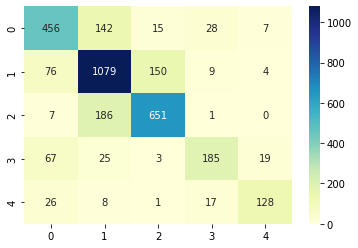

In [36]:
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       648
           1       0.75      0.82      0.78      1318
           2       0.79      0.77      0.78       845
           3       0.77      0.62      0.69       299
           4       0.81      0.71      0.76       180

    accuracy                           0.76      3290
   macro avg       0.77      0.72      0.74      3290
weighted avg       0.76      0.76      0.76      3290



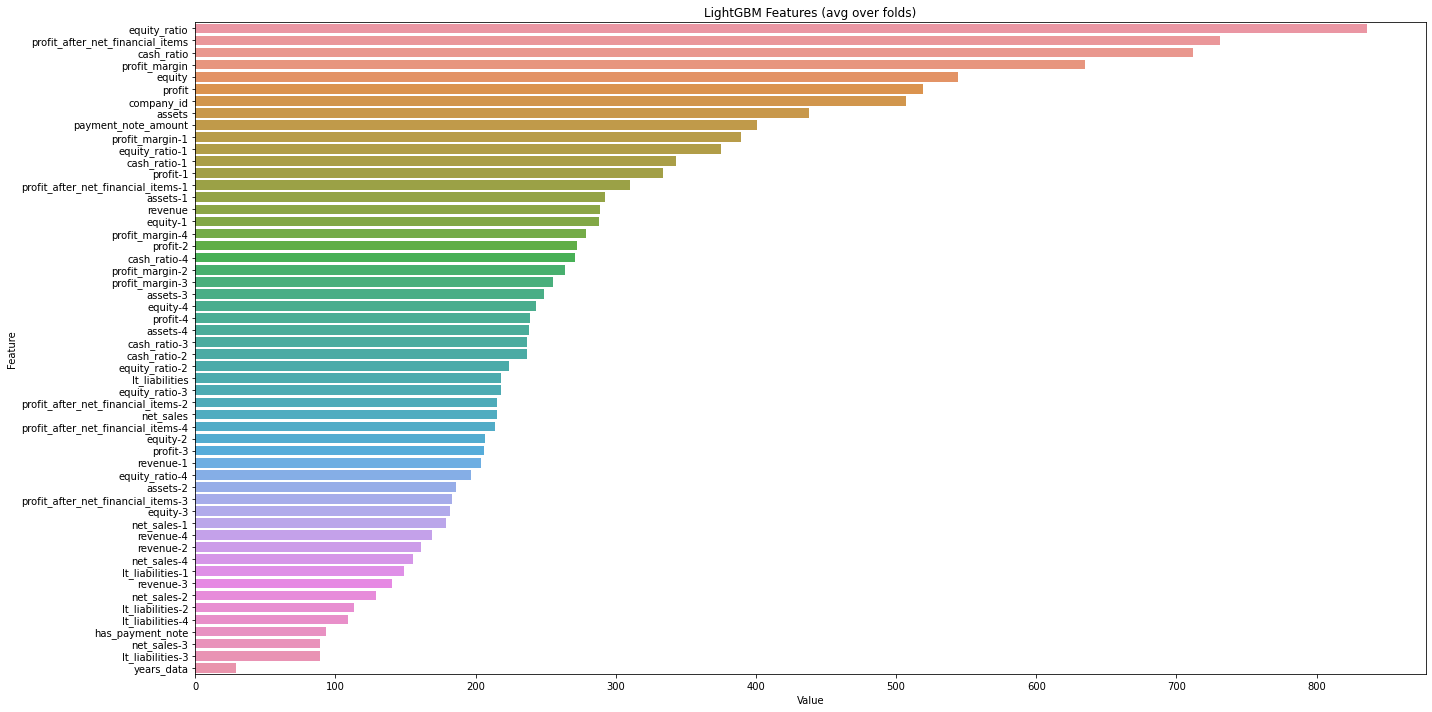

<Figure size 432x288 with 0 Axes>

In [213]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('../images/lgbm_importances.png')

## HyperParameter Tuning

In [73]:
import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

In [217]:
import lightgbm as lgbm
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    param_grid = {
        #"boosting_type": trial.suggest_categorical("boosting_type", ["dart"]),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="multiclass", class_weight='balanced', **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="multi_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, metric="multi_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [218]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

[I 2021-12-05 14:40:45,344] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=12.041159460703271, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.041159460703271
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child

[I 2021-12-05 14:40:45,991] Trial 0 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26974385264588663, 'num_leaves': 1760, 'max_depth': 9, 'min_data_in_leaf': 5900, 'lambda_l1': 25, 'lambda_l2': 55, 'min_gain_to_split': 12.041159460703271, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=12.041159460703271, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.041159460703271
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child

[I 2021-12-05 14:40:46,397] Trial 1 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15673472091872231, 'num_leaves': 1060, 'max_depth': 10, 'min_data_in_leaf': 7500, 'lambda_l1': 30, 'lambda_l2': 70, 'min_gain_to_split': 10.298033521715965, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=14.736491626745636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.736491626745636
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_dat

[I 2021-12-05 14:40:46,937] Trial 2 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09725272759520862, 'num_leaves': 500, 'max_depth': 11, 'min_data_in_leaf': 5200, 'lambda_l1': 35, 'lambda_l2': 25, 'min_gain_to_split': 14.736491626745636, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=0.41654486444674843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.41654486444674843
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_

[I 2021-12-05 14:40:47,422] Trial 3 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1238539741506205, 'num_leaves': 1020, 'max_depth': 8, 'min_data_in_leaf': 10000, 'lambda_l1': 55, 'lambda_l2': 90, 'min_gain_to_split': 0.41654486444674843, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=13.519650110919283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.519650110919283
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_dat

[I 2021-12-05 14:40:48,211] Trial 4 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28921872205016436, 'num_leaves': 2640, 'max_depth': 6, 'min_data_in_leaf': 8800, 'lambda_l1': 80, 'lambda_l2': 25, 'min_gain_to_split': 13.519650110919283, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=13.519650110919283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.519650110919283
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_dat

[I 2021-12-05 14:40:48,889] Trial 5 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24625898619594652, 'num_leaves': 2300, 'max_depth': 4, 'min_data_in_leaf': 7100, 'lambda_l1': 30, 'lambda_l2': 70, 'min_gain_to_split': 6.065439595440734, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=6.065439595440734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.065439595440734
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_s

[I 2021-12-05 14:40:49,790] Trial 6 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07860213716486393, 'num_leaves': 780, 'max_depth': 7, 'min_data_in_leaf': 2900, 'lambda_l1': 40, 'lambda_l2': 5, 'min_gain_to_split': 0.16582675886262277, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=4.936604238953292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.936604238953292
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_s

[I 2021-12-05 14:40:50,346] Trial 7 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22689616375512034, 'num_leaves': 1600, 'max_depth': 5, 'min_data_in_leaf': 5700, 'lambda_l1': 30, 'lambda_l2': 55, 'min_gain_to_split': 4.936604238953292, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=4.936604238953292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.936604238953292
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_s

[I 2021-12-05 14:40:50,893] Trial 8 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04970300562607691, 'num_leaves': 2160, 'max_depth': 9, 'min_data_in_leaf': 9700, 'lambda_l1': 0, 'lambda_l2': 45, 'min_gain_to_split': 14.084920175073476, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 1.609437911221773.
[I 2021-12-05 14:40:50,956] Trial 9 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=6.665951355257188, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.665951355257188
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in

[I 2021-12-05 14:40:56,785] Trial 10 finished with value: 0.9809233609188432 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20096086372510397, 'num_leaves': 140, 'max_depth': 12, 'min_data_in_leaf': 3000, 'lambda_l1': 0, 'lambda_l2': 95, 'min_gain_to_split': 10.971126264350325, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 10 with value: 0.9809233609188432.
[I 2021-12-05 14:40:56,967] Trial 11 pruned. Trial was pruned at iteration 101.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=9.52759057289499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.52759057289499
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_sam

[I 2021-12-05 14:41:00,216] Trial 12 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29391978171570415, 'num_leaves': 1660, 'max_depth': 12, 'min_data_in_leaf': 3400, 'lambda_l1': 10, 'lambda_l2': 80, 'min_gain_to_split': 11.50836095204297, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 10 with value: 0.9809233609188432.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.557682258497024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.557682258497024
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_dat

[I 2021-12-05 14:41:05,948] Trial 13 finished with value: 0.8911683047621926 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21465892769508693, 'num_leaves': 60, 'max_depth': 10, 'min_data_in_leaf': 1200, 'lambda_l1': 15, 'lambda_l2': 100, 'min_gain_to_split': 8.557682258497024, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 13 with value: 0.8911683047621926.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.460577012848365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.460577012848365
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_

[I 2021-12-05 14:41:08,220] Trial 14 finished with value: 0.8712960276727213 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19859135774811343, 'num_leaves': 120, 'max_depth': 10, 'min_data_in_leaf': 300, 'lambda_l1': 55, 'lambda_l2': 100, 'min_gain_to_split': 8.460577012848365, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 14 with value: 0.8712960276727213.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.319091629399813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.319091629399813
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60


[I 2021-12-05 14:41:08,586] Trial 15 pruned. Trial was pruned at iteration 101.
[I 2021-12-05 14:41:08,826] Trial 16 pruned. Trial was pruned at iteration 101.
[I 2021-12-05 14:41:09,045] Trial 17 pruned. Trial was pruned at iteration 101.
[I 2021-12-05 14:41:09,290] Trial 18 pruned. Trial was pruned at iteration 101.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=9.235952367798294, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.235952367798294
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in

[I 2021-12-05 14:41:10,738] Trial 19 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24623206540571835, 'num_leaves': 3000, 'max_depth': 11, 'min_data_in_leaf': 4100, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 9.235952367798294, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 14 with value: 0.8712960276727213.


In [219]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.87130
	Best params:
		n_estimators: 10000
		learning_rate: 0.19859135774811343
		num_leaves: 120
		max_depth: 10
		min_data_in_leaf: 300
		lambda_l1: 55
		lambda_l2: 100
		min_gain_to_split: 8.460577012848365
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.30000000000000004


In [220]:
params = study.best_params

In [224]:
tuned_clf = lgbm.LGBMClassifier(objective="multiclass", class_weight='balanced', **params)
tuned_clf.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.460577012848365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.460577012848365
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55


LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, class_weight='balanced',
               feature_fraction=0.30000000000000004, lambda_l1=55,
               lambda_l2=100, learning_rate=0.19859135774811343, max_depth=10,
               min_data_in_leaf=300, min_gain_to_split=8.460577012848365,
               n_estimators=10000, num_leaves=120, objective='multiclass')

In [225]:
y_pred = tuned_clf.predict(X_test)

In [95]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets

## Tensorflow Model

In [89]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(54, activation='relu', input_shape=(54,)),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
  ])
model

In [90]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [97]:
model.fit(X_train, y_train, batch_size=50, epochs=100)

Epoch 1/100
154/154 [==============================] - 1s 4ms/step - loss: 1.3708 - accuracy: 0.4309 - val_loss: 1.4154 - val_accuracy: 0.4006
Epoch 2/100
154/154 [==============================] - 0s 2ms/step - loss: 1.3708 - accuracy: 0.4309 - val_loss: 1.4155 - val_accuracy: 0.4006
Epoch 3/100
154/154 [==============================] - 0s 2ms/step - loss: 1.3709 - accuracy: 0.4309 - val_loss: 1.4155 - val_accuracy: 0.4006
Epoch 4/100
154/154 [==============================] - 0s 2ms/step - loss: 1.3708 - accuracy: 0.4309 - val_loss: 1.4155 - val_accuracy: 0.4006
Epoch 5/100
154/154 [==============================] - 0s 2ms/step - loss: 1.3709 - accuracy: 0.4309 - val_loss: 1.4155 - val_accuracy: 0.4006
Epoch 6/100
154/154 [==============================] - 0s 2ms/step - loss: 1.3709 - accuracy: 0.4309 - val_loss: 1.4155 - val_accuracy: 0.4006
Epoch 7/100
154/154 [==============================] - 0s 2ms/step - loss: 1.3708 - accuracy: 0.4309 - val_loss: 1.4154 - val_accuracy: 0.4006

In [98]:
model.evaluate(X_test, y_test)

103/103 [==============================] - 0s 887us/step - loss: 1.4155 - accuracy: 0.4006


[1.4154574871063232, 0.4006079137325287]

## SHAP

In [69]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

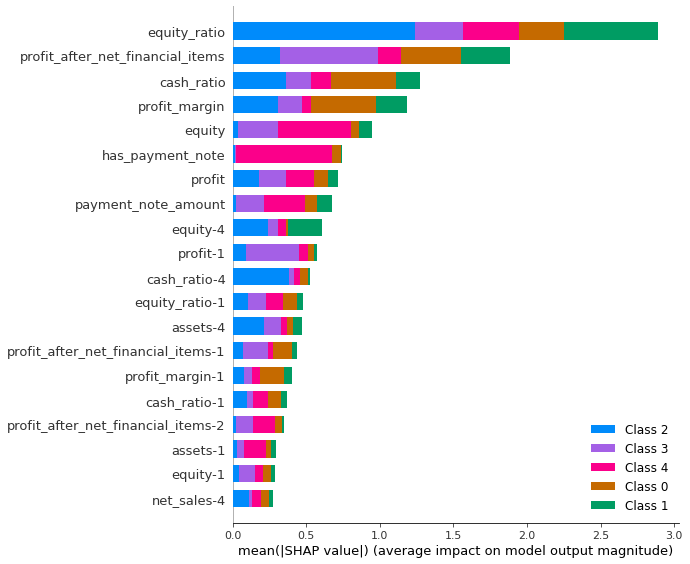

In [73]:
shap.summary_plot(shap_values, X)

In [41]:
import pickle
filename = '../models/best_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(clf, file)

In [110]:
!mlflow ui

[2021-12-05 21:09:35 +0200] [89846] [INFO] Starting gunicorn 20.1.0
[2021-12-05 21:09:35 +0200] [89846] [INFO] Listening at: http://127.0.0.1:5000 (89846)
[2021-12-05 21:09:35 +0200] [89846] [INFO] Using worker: sync
[2021-12-05 21:09:35 +0200] [89848] [INFO] Booting worker with pid: 89848
^C
[2021-12-05 21:10:55 +0200] [89846] [INFO] Handling signal: int
[2021-12-05 21:10:55 +0200] [89848] [INFO] Worker exiting (pid: 89848)
